In [ ]:
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-h2j8jopj
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-h2j8jopj
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14625 sha256=bb9f0f2e9ed737684a0e09924605bfb81509d40a3ce74335d9259e824e7694b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-81n69j64/wheels/d6/38/42/3d2112bc7d915f6195254ac85eb761d922d1b18f52817aa8e2
Successfully built mnist1d


In [ ]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Introduction
La double descent est un phénomène qui remet en question la vision classique du compromis biais-variance dans l’apprentissage automatique. Traditionnellement, on s’attend à ce que le risque de test suive une courbe en U : trop peu de paramètres conduit à un sous-apprentissage, alors qu’un trop grand nombre de paramètres provoque un surapprentissage. Cependant, dans les méthodes modernes – notamment avec les réseaux de neurones très sur-paramétrés – on observe qu’après un pic de risque au seuil d’interpolation (c’est-à-dire lorsque le modèle peut parfaitement ajuster les données d’entraînement), le risque de test diminue à nouveau. Ce comportement donne naissance à une courbe en « double descent ».


## Importation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import warnings

import mnist1d
from mnist1d.data import get_dataset_args, get_dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from torchvision import datasets, transforms


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Fonctions

In [2]:
def fix_seeds(seed=0) :
  random.seed(seed) # Fixe la graine pour le module random de Python
  np.random.seed(seed) # Fixe la graine pour NumPy
  torch.manual_seed(seed) # Fixe la graine pour PyTorch

def get_device():
   # Vérifie si CUDA (GPU) est disponible et sélectionne le dispositif approprié
  DEVICE = (torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
  return DEVICE


def init_dataset(num_samples, train_split, corr_noise_scale, iid_noise_scale, path, regenerate=False):
    args = get_dataset_args() # Récupère les arguments par défaut du jeu de données
    args.num_samples = num_samples  # Définit le nombre d'échantillons du jeu de données
    args.train_split = train_split  # Définit la proportion d'échantillons destinés à l'entraînement
    args.corr_noise_scale = corr_noise_scale # Définit l'échelle du bruit corrélé
    args.iid_noise_scale = iid_noise_scale  # Définit l'échelle du bruit indépendant identiquement distribué (iid)
    data = get_dataset(args, path=path, download=False, regenerate=regenerate) # Charge ou génère le jeu de données en fonction des arguments fournis

    return data

def inject_label_noise(y, noise_rate):

  noisy_y = y.copy() # Crée une copie des étiquettes pour ne pas modifier l'original

  # Parcourt chaque étiquette
  for i in range(len(noisy_y)):
        if random.random() < noise_rate: # Avec une probabilité égale au taux de bruit, modifie l'étiquette
            possible_labels = list(range(10))   # Liste des labels possibles
            try:
                possible_labels.remove(noisy_y[i])
            except ValueError:
                pass
            noisy_y[i] = random.choice(possible_labels)  # Attribue une nouvelle étiquette choisie aléatoirement parmi les labels restants
  return noisy_y


In [3]:
fix_seeds(0)
DEVICE = get_device()
print("Using:", DEVICE)

Using: cpu


## Double Descente sur MNIST1D avec MLP

# ⚠️ Avertissement

**Attention :** Les expérimentations 2 et 3 sont **très, très éloignées** de toute exécution "rapide". Elles nécessitent une quantité considérable de ressources et peuvent entraîner des temps de calcul extrêmement longs. Veuillez en tenir compte avant de lancer ces tests.


### Expérimentation 1 : Double Descente sur MNIST1D avec un dataset corrompu et jeu de validation

Dans ce google colab, nous étudions le phénomène de double descente dans divers scénarios. Dans un premier temps, nous analyserons la double descente (DD) sur un jeu de données comportant 10 % d’étiquettes corrompues (MNIST1D). Ce choix est justifié en expliquant comment l’ajout de bruit dans les labels accentue le phénomène de la deuxième descente.

Ensuite, nous testerons différents jeux de données en variant les taux de corruption, ce qui nous permettra d’examiner en détail cette amplification de la DD. Il est important de noter que, dans ces expériences, le jeu de données reste inchangé (le nombre d’échantillons pour entrainer et tester le modèle ne change pas) ; seuls la taille des n_hidden et le taux de corruption sont modifiés. On observe en effet un pic d’interpolation lorsque le nombre de paramètres équivaut au nombre de données d’entraînement.

Enfin, pour le MNIST1D, le dernier test consistera à utiliser divers jeux de données avec des nombres différents d’échantillons d’entraînement (n_train).
On aura ainsi, 3 jeux de données comportant respectivement 5k,10k et 15k de données.
L’objectif sera d’observer si la seconde descente se produit plus tôt ou plus tard en fonction de la taille du dataset et du nombre de n_hidden qui varie.

In [4]:
data1 = init_dataset(num_samples=12000,
                     train_split=0.7,
                     corr_noise_scale=0.3,
                     iid_noise_scale=2e-2,
                     path='./mnist1d_data.pkl',
                     regenerate=True)

# Ajout de 10% de bruit aux étiquettes d'entraînement
data1['y'] = inject_label_noise(data1['y'], noise_rate=0.1)

# Séparation de l'ensemble en entraînement et validation (15% de validation)
x_train_data1, x_val_data1, y_train_data1, y_val_data1 = train_test_split(data1['x'], data1['y'], test_size=0.15, random_state=42)

x_test_data1 ,y_test_data1 = data1['x_test'], data1['y_test']

print("Bloc 1:")
print("Exemples d'entraînement :", len(x_train_data1))
print("Exemples de validation   :", len(x_val_data1))
print("Exemples de test         :", len(x_test_data1))
print("Dimensionnalité de chaque exemple :", data1['x'].shape[-1])

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Bloc 1:
Exemples d'entraînement : 7140
Exemples de validation   : 1260
Exemples de test         : 3600
Dimensionnalité de chaque exemple : 40


In [5]:
def weight_init(layer):
    # Vérifie si la couche est de type nn.Linear
    if isinstance(layer, nn.Linear):

        nn.init.xavier_uniform_(layer.weight) # Initialise les poids de la couche avec la méthode Xavier Uniform
        nn.init.zeros_(layer.bias) # Initialise les biais de la couche à zéro

def get_model(n_hidden) :
    input_size = 40  # Taille de l'entrée (spécifique à MNIST 1D)
    hidden_size = n_hidden
    output_size = 10 # 0 à 9

    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
    )

    model.apply(weight_init)
    return model

Le seuil d'interpolation correspond au point où le nombre total de paramètres du modèle est à peu près égal au nombre d'exemples d'entraînement. Dans le cas de ton architecture, cela revient à résoudre l'équation :

Nombre paramètres = $N_{\text{train}}$

Nous considérons une architecture définie par :

- **Taille d'entrée** : 40  
- **Taille cachée** : $h$  
- **Taille de sortie** : 10

L'architecture se compose de 4 couches linéaires :
1. **Première couche (entrée → 1ère couche cachée)**  
   Le nombre de paramètres est donné par  
   $$\text{params}_1 = (40 + 1) \times h = 41h$$
   
2. **Deuxième couche (1ère couche cachée → 2ème couche cachée)**  
   Ici, on a  
   $$\text{params}_2 = (h + 1) \times h = h^2 + h$$

3. **Troisième couche (2ème couche cachée → 3ème couche cachée)**  
   De même, on obtient  
   $$\text{params}_3 = (h + 1) \times h = h^2 + h$$

4. **Quatrième couche (3ème couche cachée → sortie)**  
   Le nombre de paramètres est  
   $$\text{params}_4 = (h + 1) \times 10 = 10h + 10$$

Le nombre total de paramètres du modèle est donc :

$$\mathrm{total\_params} = \mathrm{params\_1} + \mathrm{params\_2} + \mathrm{params\_3} + \mathrm{params\_4} = 41h + (h^2 + h) + (h^2 + h) + (10h + 10)$$

<!-- $$
\text{total_params} = \text{params}_1 + \text{params}_2 + \text{params}_3 + \text{params}_4 \\
= 41h + (h^2 + h) + (h^2 + h) + (10h + 10)
$$ -->

En regroupant les termes similaires, on a :

$$
\mathrm{total_params} = 2h^2 + (41h + h + h + 10h) + 10 \\
= 2h^2 + 53h + 10
$$

Pour trouver le seuil d'interpolation, nous égalons ce nombre d'unités aux exemples d'entraînement. Sachant que
$$
N_{\text{train}} = 7140,
$$
nous avons l'équation :
$$
2h^2 + 53h + 10 = 7140.
$$

En réarrangeant, cela donne :
$$
2h^2 + 53h - 7130 = 0.
$$

Calculons le discriminant ($\Delta$) :
$$
\Delta = 53^2 + 4 \times 2 \times 7130 \\
= 2809 + 57040 \\
= 59849.
$$

La solution positive de cette équation est :

$$
h \approx \frac{-53 + 244.66}{4} \approx \frac{191.66}{4} \approx 47.92.
$$

Ainsi, le seuil d'interpolation se situe théoriquement autour de **48 variables cachées**.




In [6]:
def fit_model1(model, x_train, y_train, x_val, y_val, x_test, y_test, num_epochs):
    # Configuration du device (CPU ou GPU)
    device = next(model.parameters()).device

    # Conversion des données en tenseurs PyTorch
    x_train_tensor = torch.tensor(x_train.astype('float32'), device=device)
    y_train_tensor = torch.tensor(y_train.astype('int64').squeeze(), device=device)
    x_val_tensor = torch.tensor(x_val.astype('float32'), device=device)
    y_val_tensor = torch.tensor(y_val.astype('int64').squeeze(), device=device)

    # Modification ici : utilisation des arguments x_test et y_test
    x_test_tensor = torch.tensor(x_test.astype('float32'), device=device)
    y_test_tensor = torch.tensor(y_test.astype('int64').squeeze(), device=device)

    # Création des DataLoader pour l'entraînement et la validation
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

    # Initialisation de la fonction de perte et de l'optimiseur
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = model(x_train_tensor)
            val_preds = model(x_val_tensor)
            test_preds = model(x_test_tensor)

            train_error = 100 * (1 - (train_preds.argmax(1) == y_train_tensor).float().mean().item())
            val_error = 100 * (1 - (val_preds.argmax(1) == y_val_tensor).float().mean().item())
            test_error = 100 * (1 - (test_preds.argmax(1) == y_test_tensor).float().mean().item())

            if epoch % 100 == 0:
                print(f'Epoch {epoch:5d} | Train Error: {train_error:.2f}% | Val Error: {val_error:.2f}% | Test Error: {test_error:.2f}%')

    return train_error, val_error, test_error

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Tailles de couches cachées à tester
hidden_variables = np.array([2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 35, 40, 48, 50, 55, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 400])

# Initialiser les tableaux pour stocker les résultats
errors_train_all = np.zeros_like(hidden_variables, dtype=float)
errors_val_all = np.zeros_like(hidden_variables, dtype=float)
errors_test_all = np.zeros_like(hidden_variables, dtype=float)
total_weights_all = np.zeros_like(hidden_variables, dtype=int)

# Nombre d'époques d'entraînement
n_epoch = 500


for n_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[n_hidden]:3d} hidden variables')

    # Créer un modèle avec la taille de couche cachée actuelle
    model = get_model(hidden_variables[n_hidden])

    # Compter et stocker le nombre de paramètres du modèle
    total_weights_all[n_hidden] = count_parameters(model)

    # Entraîner le modèle
    errors_train, errors_val, errors_test = fit_model1(
        model, x_train_data1, y_train_data1, x_val_data1, y_val_data1, x_test_data1, y_test_data1, n_epoch
    )

    # Stocker les résultats
    errors_train_all[n_hidden] = errors_train
    errors_val_all[n_hidden] = errors_val
    errors_test_all[n_hidden] = errors_test

# Afficher les résultats finaux
print("\nRésultats finaux :")
for c_hidden in range(len(hidden_variables)):
    print(f"Hidden variables: {hidden_variables[c_hidden]:3d} | "
          f"Train Error: {errors_train_all[c_hidden]:.2f}% | "
          f"Val Error: {errors_val_all[c_hidden]:.2f}% | "
          f"Test Error: {errors_test_all[c_hidden]:.2f}% | "
          f"Total Weights: {total_weights_all[c_hidden]}")

Training model with   2 hidden variables
Epoch     0 | Train Error: 85.64% | Val Error: 85.95% | Test Error: 84.78%
Epoch   100 | Train Error: 73.45% | Val Error: 73.97% | Test Error: 71.97%
Epoch   200 | Train Error: 72.77% | Val Error: 74.21% | Test Error: 71.14%
Epoch   300 | Train Error: 73.39% | Val Error: 73.25% | Test Error: 70.39%
Epoch   400 | Train Error: 73.25% | Val Error: 73.81% | Test Error: 70.78%
Training model with   4 hidden variables
Epoch     0 | Train Error: 87.54% | Val Error: 88.57% | Test Error: 87.89%
Epoch   100 | Train Error: 64.31% | Val Error: 64.52% | Test Error: 61.47%
Epoch   200 | Train Error: 65.00% | Val Error: 65.40% | Test Error: 63.08%
Epoch   300 | Train Error: 64.30% | Val Error: 64.05% | Test Error: 60.06%
Epoch   400 | Train Error: 63.63% | Val Error: 65.00% | Test Error: 61.69%
Training model with   6 hidden variables
Epoch     0 | Train Error: 84.36% | Val Error: 86.43% | Test Error: 84.78%
Epoch   100 | Train Error: 59.94% | Val Error: 61.75

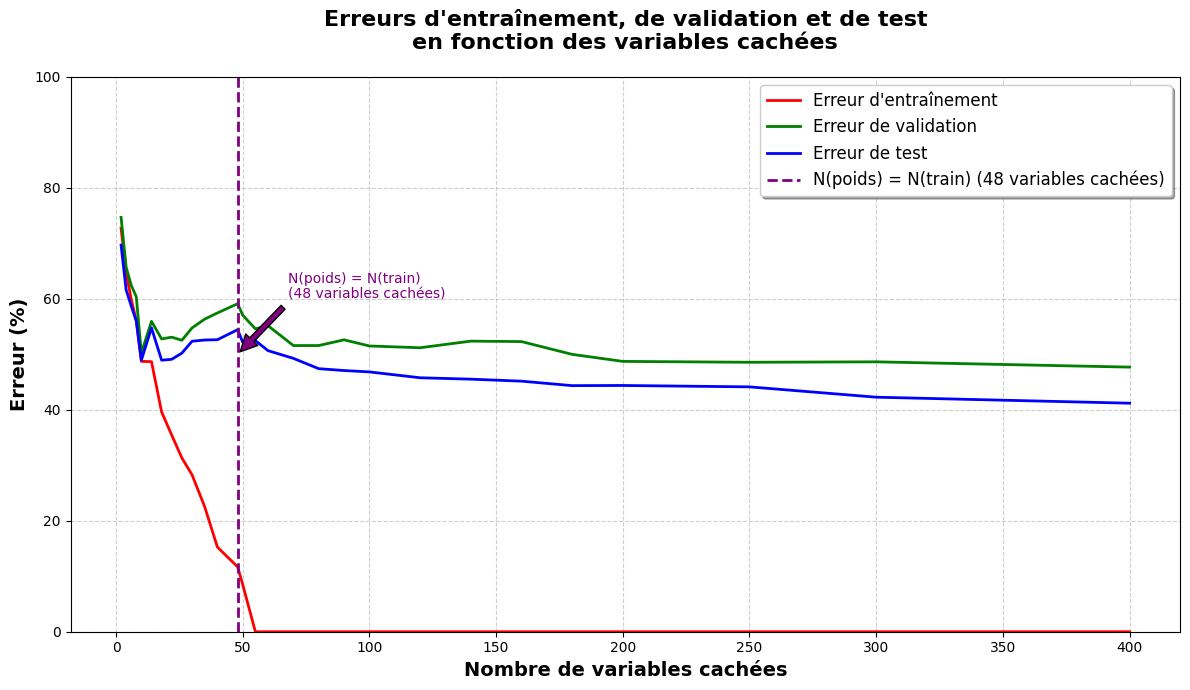

In [ ]:
def plot_results(hidden_variables, errors_train_all, errors_val_all, errors_test_all, total_weights_all, num_training_examples):
    # Trouver l'indice où total_weights_all est le plus proche de num_training_examples
    closest_index = np.argmin(np.abs(total_weights_all - num_training_examples))
    hidden_variable_at_num_training_examples = hidden_variables[closest_index]

    # Créer le graphique
    fig, ax = plt.subplots(figsize=(12, 7))

    # Tracer les erreurs d'entraînement, de validation et de test
    ax.plot(hidden_variables, errors_train_all, 'r-', linewidth=2, label='Erreur d\'entraînement')
    ax.plot(hidden_variables, errors_val_all, 'g-', linewidth=2, label='Erreur de validation')
    ax.plot(hidden_variables, errors_test_all, 'b-', linewidth=2, label='Erreur de test')

    # Ajouter une ligne verticale où N(weights) = N(train)
    ax.axvline(x=hidden_variable_at_num_training_examples, color='purple', linestyle='--', linewidth=2,
               label=f'N(poids) = N(train) ({hidden_variable_at_num_training_examples} variables cachées)')

    # Annoter le point où N(poids) = N(train)
    ax.annotate(f'N(poids) = N(train)\n({hidden_variable_at_num_training_examples} variables cachées)',
                xy=(hidden_variable_at_num_training_examples, 50),
                xytext=(hidden_variable_at_num_training_examples + 20, 60),
                arrowprops=dict(facecolor='purple', shrink=0.05),
                fontsize=10, color='purple')

    # Configurer les axes et les labels
    ax.set_ylim(0, 100)
    ax.set_xlabel('Nombre de variables cachées', fontsize=14, fontweight='bold')
    ax.set_ylabel('Erreur (%)', fontsize=14, fontweight='bold')
    ax.set_title('Erreurs d\'entraînement, de validation et de test\nen fonction des variables cachées',
                 fontsize=16, fontweight='bold', pad=20)

    # Ajouter une grille
    ax.grid(True, linestyle='--', alpha=0.6, which='both')

    # Ajouter une légende
    ax.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

    # Ajuster les marges
    fig.tight_layout()

    # Afficher le graphique
    plt.show()

num_training_examples = len(x_train_data1)
# Appeler la fonction pour tracer les résultats
plot_results(hidden_variables, errors_train_all, errors_val_all, errors_test_all, total_weights_all, num_training_examples)

On voit que l’erreur d’entraînement (courbe rouge) diminue très vite au fur et à mesure qu’on augmente la taille du réseau, jusqu’à tomber à 0% (le réseau finit par "mémoriser" tous les exemples). Du côté de la validation (courbe verte) et du test (courbe bleue), on constate d’abord une baisse, puis un léger "sursaut" autour de la ligne en pointillés (vers **48** variables cachées), qui correspond au moment où le nombre total de paramètres du modèle approche le nombre d’exemples d’entraînement (seuil d’interpolation). Passé ce point, les erreurs de validation et de test repartent à la baisse ou se stabilisent, illustrant un comportement typique de la "double descente" :

- **Avant** le seuil d’interpolation, on réduit le sous-apprentissage en augmentant la capacité.
- **Juste après** ce seuil, on observe souvent un pic de surapprentissage.
- **Enfin**, en augmentant encore la capacité, on retrouve une amélioration progressive des performances sur validation et test.

**Remarque :** Le calcul théorique donnait précisément un seuil à 48 variables cachées, ce qui concorde bien avec la courbe observée.


### Expérimentation 2 : l'impact du bruit dans les étiquettes sur la double descente


L'objectif est désormais d'analyser le phénomène de double descente en fonction de différents taux de corruption toujours sur MNIST1D.

In [ ]:
data2 = init_dataset(num_samples=12000,
                     train_split=0.7,  # Pas de séparation train/val
                     corr_noise_scale=0.3,
                     iid_noise_scale=2e-2,
                     path='./mnist1d_data.pkl',
                     regenerate=True)

x_train_data2 = data2['x']
y_train_data2 = data2['y']
x_test_data2 = data2['x_test']
y_test_data2 = data2.get('y_test')  # Peut être None si non défini

datasets_noise = {}

# Taux de bruit souhaités : 0%, 10%, 20% et 30%
for noise_rate in [0.0, 0.1, 0.2, 0.3]:
    noisy_y_train = inject_label_noise(y_train_data2, noise_rate)
    datasets_noise[noise_rate] = {
        'x_train': x_train_data2,
        'y_train': noisy_y_train,
        'x_test': x_test_data2,
        'y_test': y_test_data2
    }
    print(f"Pour un taux de bruit de {int(noise_rate * 100)}%:")
    print("  Exemples d'entraînement :", len(x_train_data2))
    print("  Exemples de test         :", len(x_test_data2))
    print("  Dimensionnalité de chaque exemple :", data2['x'].shape[-1])

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Pour un taux de bruit de 0%:
  Exemples d'entraînement : 8400
  Exemples de test         : 3600
  Dimensionnalité de chaque exemple : 40
Pour un taux de bruit de 10%:
  Exemples d'entraînement : 8400
  Exemples de test         : 3600
  Dimensionnalité de chaque exemple : 40
Pour un taux de bruit de 20%:
  Exemples d'entraînement : 8400
  Exemples de test         : 3600
  Dimensionnalité de chaque exemple : 40
Pour un taux de bruit de 30%:
  Exemples d'entraînement : 8400
  Exemples de test         : 3600
  Dimensionnalité de chaque exemple : 40


In [ ]:
def fit_model2(model, x_train, y_train, x_test, y_test, num_epochs):
    # Configuration du device (CPU ou GPU)
    device = next(model.parameters()).device

    # Conversion des données en tenseurs PyTorch
    x_train_tensor = torch.tensor(x_train.astype('float32'), device=device)
    y_train_tensor = torch.tensor(y_train.astype('int64').squeeze(), device=device)
    x_test_tensor = torch.tensor(x_test.astype('float32'), device=device)
    y_test_tensor = torch.tensor(y_test.astype('int64').squeeze(), device=device)

    # Création du DataLoader pour l'entraînement
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

    # Initialisation de la fonction de perte et de l'optimiseur
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Évaluation du modèle sur l'ensemble d'entraînement et de test
        model.eval()
        with torch.no_grad():
            train_preds = model(x_train_tensor)
            test_preds = model(x_test_tensor)
            train_error = 100 * (1 - (train_preds.argmax(1) == y_train_tensor).float().mean().item())
            test_error = 100 * (1 - (test_preds.argmax(1) == y_test_tensor).float().mean().item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Train Error: {train_error:.2f}% | Test Error: {test_error:.2f}%")

    return train_error, test_error

In [ ]:
# Tailles de couches cachées à tester
hidden_variables = np.array([2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 35, 40, 48, 50, 55, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 400])
noise_levels = sorted(datasets_noise.keys())
num_noise = len(noise_levels)
num_hidden = len(hidden_variables)

# Initialiser les tableaux pour stocker les résultats
errors_train_all = np.zeros((num_noise, num_hidden), dtype=float)
errors_test_all  = np.zeros((num_noise, num_hidden), dtype=float)
total_weights_all = np.zeros((num_noise, num_hidden), dtype=int)

# Nombre d'époques d'entraînement ( ici 400 pour accélerer le processur déjà très long)
n_epoch = 400

for i, noise in enumerate(noise_levels):
    # Récupérer le jeu de données correspondant au taux de bruit 'noise'
    ds = datasets_noise[noise]
    x_train = ds['x_train']  # Utilisation complète de l'ensemble d'entraînement
    y_train = ds['y_train']
    x_test  = ds['x_test']
    y_test  = ds['y_test']

    for j, n_hidden in enumerate(hidden_variables):
        print(f"Noise level: {noise:.2f} - Training model with {n_hidden:3d} hidden variables")

        # Créer le modèle avec le nombre de variables cachées courant
        model = get_model(n_hidden)

        # Compter et stocker le nombre total de poids
        total_weights_all[i, j] = count_parameters(model)

        # Entraîner le modèle sans validation
        train_err, test_err = fit_model2(model, x_train, y_train, x_test, y_test, n_epoch)

        # Stocker les erreurs
        errors_train_all[i, j] = train_err
        errors_test_all[i, j]  = test_err

Noise level: 0.00 - Training model with   2 hidden variables
Epoch     0 | Train Error: 83.93% | Test Error: 83.47%
Epoch   100 | Train Error: 71.04% | Test Error: 70.86%
Epoch   200 | Train Error: 70.71% | Test Error: 71.22%
Epoch   300 | Train Error: 70.17% | Test Error: 70.83%
Noise level: 0.00 - Training model with   4 hidden variables
Epoch     0 | Train Error: 85.40% | Test Error: 86.00%
Epoch   100 | Train Error: 61.26% | Test Error: 60.97%
Epoch   200 | Train Error: 60.71% | Test Error: 60.72%
Epoch   300 | Train Error: 59.55% | Test Error: 60.25%
Noise level: 0.00 - Training model with   6 hidden variables
Epoch     0 | Train Error: 81.85% | Test Error: 82.33%
Epoch   100 | Train Error: 54.85% | Test Error: 56.97%
Epoch   200 | Train Error: 54.02% | Test Error: 55.72%
Epoch   300 | Train Error: 53.26% | Test Error: 54.47%
Noise level: 0.00 - Training model with   8 hidden variables
Epoch     0 | Train Error: 80.98% | Test Error: 82.19%
Epoch   100 | Train Error: 54.58% | Test 

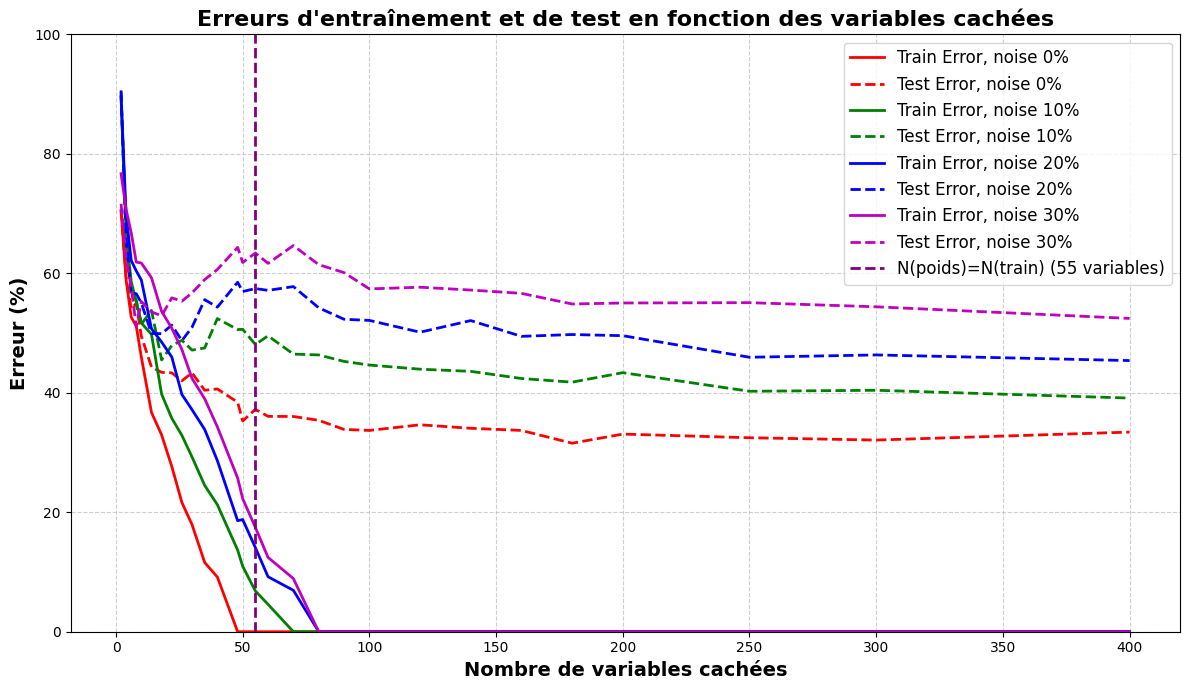

In [ ]:
def plot_results_no_val(hidden_variables, errors_train_all, errors_test_all, total_weights_all, num_training_examples, noise_levels):

  # Couleurs à utiliser pour les 4 jeux de données
    colors = ['r', 'g', 'b', 'm']

    # Trouver l'indice où, pour le premier jeu (architecture identique), le nombre total de poids est le plus proche de num_training_examples
    closest_index = np.argmin(np.abs(total_weights_all[0] - num_training_examples))
    hidden_at_train_examples = hidden_variables[closest_index]

    plt.figure(figsize=(12, 7))

    # Tracer pour chaque taux de bruit
    for i, noise in enumerate(noise_levels):
        plt.plot(hidden_variables, errors_train_all[i], color=colors[i], linestyle='-', linewidth=2,
                 label=f"Train Error, noise {int(noise*100)}%")
        plt.plot(hidden_variables, errors_test_all[i], color=colors[i], linestyle='--', linewidth=2,
                 label=f"Test Error, noise {int(noise*100)}%")

    # Ajouter la ligne verticale
    plt.axvline(x=hidden_at_train_examples, color='purple', linestyle='--', linewidth=2,
                label=f"N(poids)=N(train) ({hidden_at_train_examples} variables)")

    plt.xlabel("Nombre de variables cachées", fontsize=14, fontweight='bold')
    plt.ylabel("Erreur (%)", fontsize=14, fontweight='bold')
    plt.title("Erreurs d'entraînement et de test en fonction des variables cachées",
              fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Nombre d'exemples d'entraînement (à adapter selon votre dataset)
num_training_examples = len(datasets_noise[noise_levels[0]]['x_train'])

# Appeler la fonction pour tracer les résultats
plot_results_no_val(hidden_variables, errors_train_all, errors_test_all, total_weights_all, num_training_examples, noise_levels)

Sur ce graphique, chaque courbe représente l’erreur d’entraînement et l’erreur de test pour différents taux de bruit (0%, 5%, 10%, 20%, 30%). On note les points suivants :

1. **Même position du seuil d’interpolation :**  
   Le seuil d'interpolation se produit à la même abscisse pour tous les niveaux de bruit (vers **55 variables cachées**). C’est logique puisque ce seuil dépend principalement du rapport entre le nombre total de paramètres et le nombre d’exemples d’entraînement, qui est identique pour toutes les expériences.

2. **Ampleur du pic selon le bruit :**  
   Bien que la position du pic soit la même, on constate qu’il est **plus ou moins prononcé** selon le taux de corruption. Plus le bruit est élevé, plus la remontée d’erreur de test est forte. En d’autres termes, le phénomène de double descente est **amplifié** lorsque le bruit augmente.

3. **Cas sans bruit (0% de corruption) :**  
   Pour la courbe «0%», on n’observe pas de vrai pic de double descente. L’apprentissage est plus stable, car il n’y a pas de labels contradictoires à «sur-apprendre».


### Expérimentation 3 :  Impact de la taille du dataset MNIST1D sur la double descente (taux de corruption constant)


L'objectif ici est d'évaluer le phénomène de double descente en utilisant trois ensembles de données de tailles différentes afin d'observer ses effets.
Cependant, le taux de corruption reste le même pour les 3 datasets.

In [ ]:
data3 = init_dataset(num_samples=40000,
                     train_split=0.75,
                     corr_noise_scale=0.3,
                     iid_noise_scale=2e-2,
                     path='./mnist1d_data.pkl',
                     regenerate=True)

total_samples = len(data3['x'])
print(f"Total samples available: {total_samples}")

# Définir les tailles d'entraînement souhaitées (exemple : 5000, 10000, 15000)
train_sizes = [5000, 10000, 15000]
max_train_size = int(total_samples * 0.75)  # 75% du dataset total

# On s'assure que les tailles demandées sont possibles
train_sizes = [size for size in train_sizes if size <= max_train_size]
print(f"Adjusted train sizes: {train_sizes}")

datasets_sizes = {}

for size in train_sizes:
    # Extraire un sous-ensemble de taille 'size'
    x_train_sub, _, y_train_sub, _ = train_test_split(
        data3['x'], data3['y'], train_size=size, random_state=42
    )
    # Ajouter 20% de bruit aux labels
    y_train_noisy = inject_label_noise(y_train_sub, noise_rate=0.2)
    datasets_sizes[size] = {
        'x_train': x_train_sub,
        'y_train': y_train_noisy,
        'x_test': data3['x_test'],
        'y_test': data3['y_test']
    }

print("Datasets créés avec des labels bruités (20%).")

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Total samples available: 30000
Adjusted train sizes: [5000, 10000, 15000]
Datasets créés avec des labels bruités (20%).


In [ ]:
def prepare_dataloader(x_train, y_train, x_test, y_test, batch_size=100):
    x_train_tensor = torch.tensor(x_train.astype('float32'))
    y_train_tensor = torch.tensor(y_train.astype('int64').squeeze())
    x_test_tensor = torch.tensor(x_test.astype('float32'))
    y_test_tensor = torch.tensor(y_test.astype('int64').squeeze())

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Créer les DataLoaders pour chaque dataset
for size in train_sizes:
    datasets_sizes[size]['train_loader'], datasets_sizes[size]['test_loader'] = prepare_dataloader(
        datasets_sizes[size]['x_train'], datasets_sizes[size]['y_train'],
        datasets_sizes[size]['x_test'], datasets_sizes[size]['y_test']
    )


In [ ]:
def fit_model3(model, train_loader, test_loader, num_epochs=500):
    device = next(model.parameters()).device

    # Transfère le modèle sur le dispositif identifié (CPU ou GPU)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss() # Définition de la fonction de perte
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Définition de l'optimiseur (SGD avec un taux d'apprentissage de 0.01 et un momentum de 0.9)

    # Boucle d'entraînement sur le nombre d'époques spécifié
    for epoch in range(num_epochs):
        # Met le modèle en mode entraînement
        model.train()

        # Parcourt les batches d'entraînement dans train_loader
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device) # Transfère les entrées et étiquettes sur le dispositif sélectionné

            optimizer.zero_grad() # Réinitialise les gradients des paramètres

            outputs = model(inputs) # Réinitialise les gradients des paramètres

            loss = criterion(outputs, labels) # Calcule la perte entre les sorties prédites et les étiquettes réelles

            loss.backward() # Rétropropagation de l'erreur pour calculer les gradients

            optimizer.step() # Mise à jour des paramètres du modèle par l'optimiseur

        model.eval() # Évaluation du modèle en mode validation (sans calcul de gradients)
        with torch.no_grad():

            train_error = 100 * (1 - (model(inputs).argmax(1) == labels).float().mean().item()) # Calcul de l'erreur sur le dernier batch d'entraînement
            test_error = 100 * (1 - (model(next(iter(test_loader))[0].to(device)).argmax(1) ==
                                     next(iter(test_loader))[1].to(device)).float().mean().item()) # Calcul de l'erreur sur un batch du test_loader
        # Affichage de l'erreur tous les 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Train Error: {train_error:.2f}% | Test Error: {test_error:.2f}%")

    return train_error, test_error


In [ ]:
hidden_variables = np.array([10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 200, 250, 300]) # Définition d'un tableau de différentes tailles de variables cachées à tester
num_epochs = 500 # Définition du nombre d'époques d'entraînement


# Initialisation des dictionnaires pour stocker les erreurs d'entraînement et de test
errors_train = {size: np.zeros_like(hidden_variables, dtype=float) for size in train_sizes}
errors_test = {size: np.zeros_like(hidden_variables, dtype=float) for size in train_sizes}

# Parcours de chaque taille d'échantillon d'entraînement
for size in train_sizes:
    for i, n_hidden in enumerate(hidden_variables):
        print(f"\nTraining model with {n_hidden} hidden variables ({size} training samples)")
        model = get_model(n_hidden)
        errors_train[size][i], errors_test[size][i] = fit_model3(model, datasets_sizes[size]['train_loader'], datasets_sizes[size]['test_loader'], num_epochs)



Training model with 10 hidden variables (5000 training samples)
Epoch     0 | Train Error: 90.00% | Test Error: 83.00%
Epoch   100 | Train Error: 73.00% | Test Error: 59.00%
Epoch   200 | Train Error: 58.00% | Test Error: 62.00%
Epoch   300 | Train Error: 64.00% | Test Error: 60.00%
Epoch   400 | Train Error: 56.00% | Test Error: 55.00%

Training model with 20 hidden variables (5000 training samples)
Epoch     0 | Train Error: 82.00% | Test Error: 80.00%
Epoch   100 | Train Error: 47.00% | Test Error: 54.00%
Epoch   200 | Train Error: 45.00% | Test Error: 60.00%
Epoch   300 | Train Error: 45.00% | Test Error: 61.00%
Epoch   400 | Train Error: 55.00% | Test Error: 63.00%

Training model with 30 hidden variables (5000 training samples)
Epoch     0 | Train Error: 84.00% | Test Error: 82.00%
Epoch   100 | Train Error: 43.00% | Test Error: 63.00%
Epoch   200 | Train Error: 39.00% | Test Error: 62.00%
Epoch   300 | Train Error: 29.00% | Test Error: 63.00%
Epoch   400 | Train Error: 28.00% |

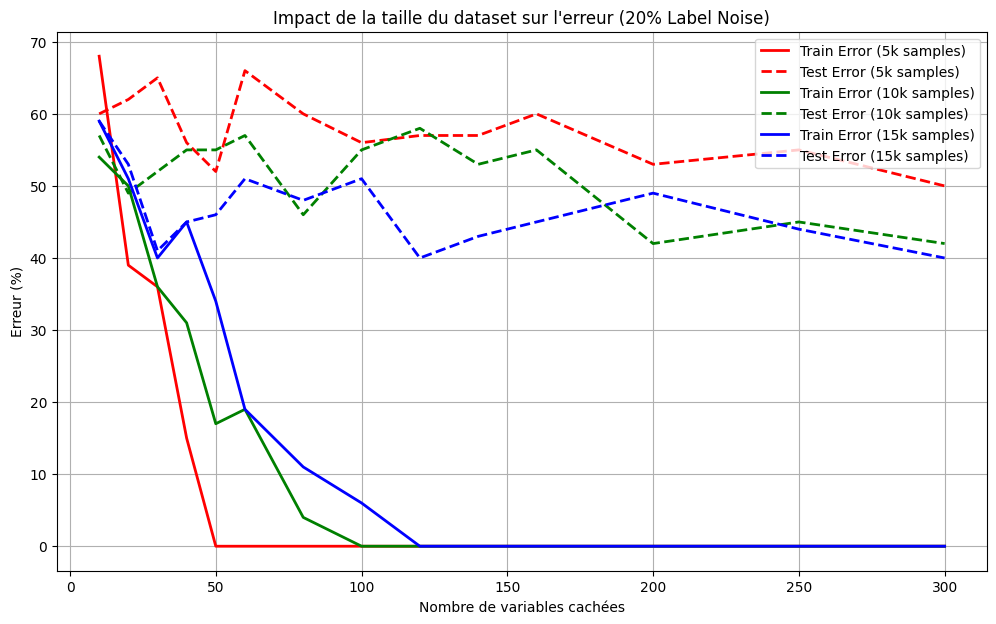

In [ ]:
plt.figure(figsize=(12, 7))

# Couleurs pour chaque dataset
colors = ['r', 'g', 'b']
labels = ["5k samples", "10k samples", "15k samples"]

for i, size in enumerate(train_sizes):
    plt.plot(hidden_variables, errors_train[size], color=colors[i], linestyle='-', linewidth=2, label=f"Train Error ({labels[i]})")
    plt.plot(hidden_variables, errors_test[size], color=colors[i], linestyle='--', linewidth=2, label=f"Test Error ({labels[i]})")

plt.xlabel("Nombre de variables cachées")
plt.ylabel("Erreur (%)")
plt.title("Impact de la taille du dataset sur l'erreur (20% Label Noise)")
plt.legend()
plt.grid(True)
plt.show()


Sur ce plot, on observe trois paires de courbes (train et test) correspondant à trois tailles de dataset (5k, 10k et 15k exemples), toutes soumises à **20% de bruit dans les étiquettes** :

- **Erreur d’entraînement** (traits pleins) :  
  - Pour chaque taille de dataset, plus le nombre de variables cachées augmente, plus l’erreur d’entraînement diminue, jusqu’à atteindre quasiment 0.  
  - Ce comportement illustre que le réseau finit par «mémoriser» les données, même lorsque 20% des labels sont corrompus.

- **Erreur de test** (pointillés) :  
  - De manière générale, plus le dataset est grand, plus le niveau final d’erreur de test est bas (la courbe «15k» finit en dessous de la «10k», elle-même en dessous de la «5k»).

**Pic d’interpolation selon la taille du dataset :**  
Le seuil d'interpolation survient lorsque la capacité du réseau se rapproche du nombre d’exemples d’entraînement. Ici, on constate que plus on dispose d’exemples (5k, 10k, 15k), plus ce point d’interpolation est décalé vers la droite (un plus grand nombre de variables cachées est nécessaire pour atteindre ce seuil). Cela se traduit par un «pic» qui se produit plus tard pour les ensembles de données plus volumineux.


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.27MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.25MB/s]



==> Test pour weight_decay = 0.0
  Taille d'échantillon: 100
  Taille d'échantillon: 200
  Taille d'échantillon: 500
  Taille d'échantillon: 800
  Taille d'échantillon: 1000
  Taille d'échantillon: 1500
  Taille d'échantillon: 2000
  Taille d'échantillon: 2500
  Taille d'échantillon: 4000
  Taille d'échantillon: 5000
  Taille d'échantillon: 6000
  Taille d'échantillon: 7000
  Taille d'échantillon: 8000
  Taille d'échantillon: 9000
  Taille d'échantillon: 10000
  Taille d'échantillon: 13000
  Taille d'échantillon: 15000
  Taille d'échantillon: 20000
  Taille d'échantillon: 25000
  Taille d'échantillon: 30000
  Taille d'échantillon: 40000

==> Test pour weight_decay = 0.1
  Taille d'échantillon: 100
  Taille d'échantillon: 200
  Taille d'échantillon: 500
  Taille d'échantillon: 800
  Taille d'échantillon: 1000
  Taille d'échantillon: 1500
  Taille d'échantillon: 2000
  Taille d'échantillon: 2500
  Taille d'échantillon: 4000
  Taille d'échantillon: 5000
  Taille d'échantillon: 6000
  Tai

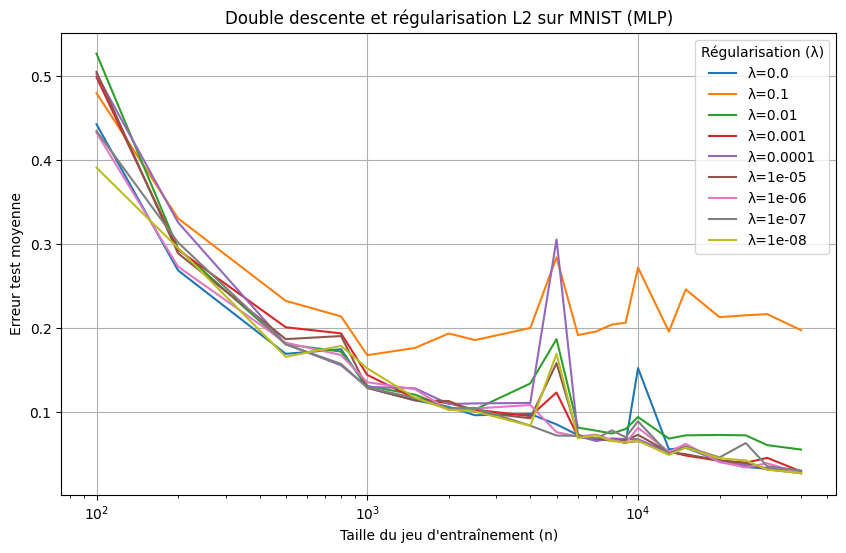

In [7]:
# ---- Définition du modèle ---- #
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 10)

        # Initialisation He (Kaiming)
        nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear3.weight, nonlinearity='linear')  # Pas de ReLU après

        nn.init.zeros_(self.linear1.bias)
        nn.init.zeros_(self.linear2.bias)
        nn.init.zeros_(self.linear3.bias)

        self.net = nn.Sequential(
            nn.Flatten(),
            self.linear1,
            nn.ReLU(),
            self.linear2,
            nn.ReLU(),
            self.linear3
        )

    def forward(self, x):
        return self.net(x)


# ---- Préparation des données ---- #
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# ---- Paramètres d’expérience ---- #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_sizes = [100, 200, 500, 800, 1000, 1500, 2000, 2500, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 13000, 15000, 20000, 25000, 30000, 40000]
weight_decays = [0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]  # différents lambdas
runs = 3
epochs = 10
batch_size = 128

# ---- Boucle principale ---- #
results = {f"λ={wd}": [] for wd in weight_decays}

for wd_value in weight_decays:
    label = f"λ={wd_value}"
    print(f"\n==> Test pour weight_decay = {wd_value}")
    for n in sample_sizes:
        test_errors = []
        print(f"  Taille d'échantillon: {n}")
        for run in range(runs):
            indices = random.sample(range(len(train_dataset)), n)
            train_subset = Subset(train_dataset, indices)
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

            model = MLP().to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=wd_value)

            for epoch in range(epochs):
                model.train()
                for x, y in train_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss = F.cross_entropy(logits, y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    preds = torch.argmax(logits, dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)

            error = 1 - (correct / total)
            test_errors.append(error)

        avg_error = np.mean(test_errors)
        results[label].append(avg_error)

# ---- Affichage des résultats ---- #
plt.figure(figsize=(10, 6))
for label, errors in results.items():
    plt.plot(sample_sizes, errors, label=label)
plt.xlabel("Taille du jeu d'entraînement (n)")
plt.ylabel("Erreur test moyenne")
plt.title("Double descente et régularisation L2 sur MNIST (MLP)")
plt.legend(title="Régularisation (λ)")
plt.grid(True)
plt.xscale('log')
plt.show()
